# Bibliotecas

In [2]:
# basicas
import findspark
findspark.init()

import pyspark

from pyspark.sql import SparkSession

from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType)
from pyspark.sql.functions import col,when, explode, array, lit
from pyspark.ml.feature import VectorAssembler,MinMaxScaler,StringIndexer, OneHotEncoder,StandardScaler, VectorSlicer,PCA

from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.stat import Correlation

from pyspark.ml import Pipeline

import matplotlib.pyplot as plt


# Cargar los datos de la base de datos

In [3]:
from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType)

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/19 22:06:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [4]:
df_Heart_country = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "Heart_country") \
    .load()

In [5]:
df_Heart_country.printSchema()

root
 |-- Age: float (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Cholesterol: float (nullable = true)
 |-- Heart Rate: float (nullable = true)
 |-- Diabetes: float (nullable = true)
 |-- Family History: float (nullable = true)
 |-- Smoking: float (nullable = true)
 |-- Obesity: float (nullable = true)
 |-- Alcohol Consumption: float (nullable = true)
 |-- Exercise Hours Per Week: float (nullable = true)
 |-- Diet: string (nullable = true)
 |-- Previous Heart Problems: float (nullable = true)
 |-- Medication Use: float (nullable = true)
 |-- Stress Level: float (nullable = true)
 |-- Sedentary Hours Per Day: float (nullable = true)
 |-- Income: float (nullable = true)
 |-- BMI: float (nullable = true)
 |-- Triglycerides: float (nullable = true)
 |-- Physical Activity Days Per Week: float (nullable = true)
 |-- Sleep Hours Per Day: float (nullable = true)
 |-- Country: string (nullable = true)
 |-- systolic: float (nullable = true)
 |-- diastolic: float (nullable = true)
 |

In [6]:
df_Heart_country.show(1)

23/10/19 22:06:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+------+-----------+----------+--------+--------------+-------+-------+-------------------+-----------------------+-------+-----------------------+--------------+------------+-----------------------+-------+----+-------------+-------------------------------+-------------------+-------+--------+---------+---------------------+----------------------+------------+-----------------+--------------------+------------------------------+--------------------------+---------------+-------------+-----------------+
| Age|   Sex|Cholesterol|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|   Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day| Income| BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|Country|systolic|diastolic|Quality of Life Index|Purchasing Power Index|Safety Index|Health Care Index|Cost of Living Index|Property Price to Income Ratio|Traffic Commute Time Index|Pollution Index|Clima

In [7]:
print((df_Heart_country.count(), len(df_Heart_country.columns)))

(8763, 33)


# Modelo de predicción.

### Entendamos los datos para saber el mejor metodo para scalar o/y si deben balanciados  en el pipeline

## Visualizacion para saber si estan balanciado

In [8]:
Heart_counts = df_Heart_country.groupBy("Heart Attack Risk").count().orderBy("Heart Attack Risk")
# Convierte el DataFrame de Spark a un DataFrame de pandas
Heart_counts_pd = Heart_counts.toPandas()

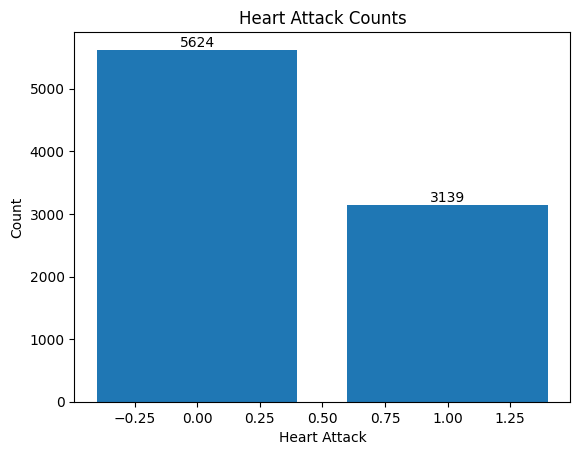

In [9]:
Heart_counts = df_Heart_country.groupBy("Heart Attack Risk").count().orderBy("Heart Attack Risk")
# Convierte el DataFrame de Spark a un DataFrame de pandas
Heart_counts_pd = Heart_counts.toPandas()

# Crea el gráfico de barras con Matplotlib
plt.bar(Heart_counts_pd["Heart Attack Risk"], Heart_counts_pd["count"])
plt.xlabel("Heart Attack")
plt.ylabel("Count")
plt.title("Heart Attack Counts")

# Establece las etiquetas en el eje x
plt.xticks(rotation=0)  # Puedes ajustar el ángulo de rotación si es necesario

# Agrega etiquetas de texto con los números en las barras
for i, count in enumerate(Heart_counts_pd["count"]):
    plt.text(i, count + 1, str(count), ha="center", va="bottom", fontsize=10)

plt.show()

## Revisar valores atipicos


En este caso al no poder graficar todos los valores, un metodo que podemos utiliziar para detectar  "outliers" es  el test de Tukey [1]. EL cual se basa en los cuartiles uno y tres para de estos valores. Adicionalmnete podriamos con los datos estaditicos anterior podria escoger solo algunas columnas.


**Nota**: Para este caso al conocer los datos por el prepocesamiento ya hecho, se decide no filtrar lo.



In [15]:
excluir=["Heart Attack Risk",'Sex','Diet','Country']
columnas_number = [col for col in df_Heart_country.columns if col not in excluir]


# Iterar sobre las columnas y contar los valores atípicos
for columna_objetivo in columnas_number:
    quartiles = df_Heart_country.approxQuantile(columna_objetivo, [0.25, 0.75], 0.05)
    Q1 = quartiles[0]
    Q3 = quartiles[1]
    #print(Q1,Q3)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = df_Heart_country.filter((col(columna_objetivo) < lower_bound) | (col(columna_objetivo) > upper_bound)).count()

    # Mostrar el total de valores atípicos
    print(f"Total de valores atípicos en '{columna_objetivo}': {outliers_count}")


Total de valores atípicos en 'Age': 0
Total de valores atípicos en 'Cholesterol': 0
Total de valores atípicos en 'Heart Rate': 0
Total de valores atípicos en 'Diabetes': 0
Total de valores atípicos en 'Family History': 0
Total de valores atípicos en 'Smoking': 904
Total de valores atípicos en 'Obesity': 0
Total de valores atípicos en 'Alcohol Consumption': 0
Total de valores atípicos en 'Exercise Hours Per Week': 0
Total de valores atípicos en 'Previous Heart Problems': 0
Total de valores atípicos en 'Medication Use': 0
Total de valores atípicos en 'Stress Level': 0
Total de valores atípicos en 'Sedentary Hours Per Day': 0
Total de valores atípicos en 'Income': 0
Total de valores atípicos en 'BMI': 0
Total de valores atípicos en 'Triglycerides': 0
Total de valores atípicos en 'Physical Activity Days Per Week': 0
Total de valores atípicos en 'Sleep Hours Per Day': 0
Total de valores atípicos en 'systolic': 0
Total de valores atípicos en 'diastolic': 0
Total de valores atípicos en 'Quali

## Clases categorias

In [9]:
string_columns = [f.name for f in df_Heart_country.schema.fields if isinstance(f.dataType, StringType)]
string_columns

['Sex', 'Diet', 'Country']

### Categoricas ordinales

Pasar las clases categóricas ordinales a números. En este caso, 'Sexo' es binaria, y 'Diet' es ordinal, por lo que podemos numerarlas con facilidad

Sex
- Male: 0
- Female: 1

Diet
- Unhealthy: 0
- Average: 1
- Healthy: 2

In [10]:
# Define los diccionarios de mapeo
sexo_dict = {
    "Male": '0',
    "Female": '1'
}

diet_dict = {
    "Unhealthy": '0',
    "Average": '1',
    "Healthy": '2'
}

df_Heart_country = df_Heart_country.replace(sexo_dict,subset=['Sex'])
df_Heart_country = df_Heart_country.replace(diet_dict,subset=['Diet'])

df_Heart_country = df_Heart_country.withColumn('Sex', col('Sex').cast('float'))
df_Heart_country = df_Heart_country.withColumn('Diet', col('Diet').cast('float'))

### Categoricas nominales 
Para este caso que seria la columnas "Country" aplicaremos un `OneHotEncoder`, para lo cula primero creamos un index numerico de cada clase

In [11]:
Country_counts = df_Heart_country.groupBy("Country").count().orderBy("Country")
# Convierte el DataFrame de Spark a un DataFrame de pandas
Country_counts_pd = Country_counts.toPandas()
Country_counts_pd

,Country,count
0,Argentina,471
1,Australia,449
2,Brazil,462
3,Canada,440
4,China,436
5,Colombia,429
6,France,446
7,Germany,477
8,India,412
9,Italy,431


In [12]:
# StringIndexer
string_indexer = StringIndexer(inputCol='Country', outputCol='Country_index')
indexer_model = string_indexer.fit(df_Heart_country)
df_Heart_country = indexer_model.transform(df_Heart_country)


# OneHotEncoder
encoder = OneHotEncoder(inputCol='Country_index', outputCol='Country_encoded')
encoder_model = encoder.fit(df_Heart_country)
df_Heart_country = encoder_model.transform(df_Heart_country)
df_Heart_country=df_Heart_country.drop('Country','Country_index')
df_Heart_country

DataFrame[Age: float, Sex: float, Cholesterol: float, Heart Rate: float, Diabetes: float, Family History: float, Smoking: float, Obesity: float, Alcohol Consumption: float, Exercise Hours Per Week: float, Diet: float, Previous Heart Problems: float, Medication Use: float, Stress Level: float, Sedentary Hours Per Day: float, Income: float, BMI: float, Triglycerides: float, Physical Activity Days Per Week: float, Sleep Hours Per Day: float, systolic: float, diastolic: float, Quality of Life Index: float, Purchasing Power Index: float, Safety Index: float, Health Care Index: float, Cost of Living Index: float, Property Price to Income Ratio: float, Traffic Commute Time Index: float, Pollution Index: float, Climate Index: float, Heart Attack Risk: float, Country_encoded: vector]

### Nuevas columnas

In [13]:
df_Heart_country.select('Sex','Diet','Country_encoded').show(50)
#df_Heart_country=df_Heart_country.drop('Country_encoded')

+---+----+---------------+
|Sex|Diet|Country_encoded|
+---+----+---------------+
|1.0| 1.0| (19,[8],[1.0])|
|1.0| 2.0| (19,[2],[1.0])|
|1.0| 1.0| (19,[0],[1.0])|
|1.0| 2.0| (19,[0],[1.0])|
|1.0| 1.0|(19,[16],[1.0])|
|1.0| 0.0| (19,[1],[1.0])|
|1.0| 2.0| (19,[5],[1.0])|
|1.0| 2.0| (19,[1],[1.0])|
|1.0| 1.0| (19,[9],[1.0])|
|1.0| 2.0| (19,[6],[1.0])|
|1.0| 0.0| (19,[2],[1.0])|
|1.0| 0.0| (19,[9],[1.0])|
|1.0| 2.0|(19,[16],[1.0])|
|1.0| 2.0|(19,[13],[1.0])|
|1.0| 0.0|(19,[13],[1.0])|
|1.0| 0.0| (19,[0],[1.0])|
|1.0| 0.0| (19,[7],[1.0])|
|1.0| 2.0| (19,[4],[1.0])|
|1.0| 2.0|(19,[14],[1.0])|
|1.0| 2.0|(19,[13],[1.0])|
|1.0| 1.0|(19,[15],[1.0])|
|1.0| 0.0|(19,[10],[1.0])|
|1.0| 0.0|(19,[12],[1.0])|
|1.0| 1.0|(19,[13],[1.0])|
|1.0| 2.0|(19,[18],[1.0])|
|1.0| 2.0| (19,[6],[1.0])|
|1.0| 1.0|(19,[17],[1.0])|
|1.0| 1.0| (19,[6],[1.0])|
|1.0| 2.0|     (19,[],[])|
|1.0| 2.0|(19,[16],[1.0])|
|1.0| 0.0| (19,[1],[1.0])|
|1.0| 1.0|(19,[14],[1.0])|
|1.0| 2.0|(19,[11],[1.0])|
|0.0| 0.0| (19,[0],[1.0])|
|

## Vectorizamos para utilizar la libreria Mlab

In [14]:
features = [c for c in df_Heart_country.columns if c != "Heart Attack Risk"]
len(features)

32

In [15]:
assembler = VectorAssembler(
    inputCols=features,
    outputCol='features')

vector_df = assembler.transform(df_Heart_country)
vector_df = vector_df.select(['features','Heart Attack Risk'])
vector_df.show()

+--------------------+-----------------+
|            features|Heart Attack Risk|
+--------------------+-----------------+
|(50,[0,1,2,3,5,7,...|              0.0|
|(50,[0,1,2,3,4,5,...|              0.0|
|(50,[0,1,2,3,4,8,...|              0.0|
|(50,[0,1,2,3,4,5,...|              0.0|
|(50,[0,1,2,3,4,7,...|              0.0|
|(50,[0,1,2,3,4,5,...|              0.0|
|(50,[0,1,2,3,8,9,...|              0.0|
|(50,[0,1,2,3,7,8,...|              0.0|
|(50,[0,1,2,3,4,8,...|              0.0|
|(50,[0,1,2,3,4,5,...|              0.0|
|(50,[0,1,2,3,4,5,...|              1.0|
|(50,[0,1,2,3,9,11...|              1.0|
|(50,[0,1,2,3,4,9,...|              0.0|
|(50,[0,1,2,3,8,9,...|              1.0|
|(50,[0,1,2,3,5,7,...|              0.0|
|(50,[0,1,2,3,5,7,...|              0.0|
|(50,[0,1,2,3,5,7,...|              0.0|
|(50,[0,1,2,3,5,7,...|              0.0|
|(50,[0,1,2,3,5,8,...|              0.0|
|(50,[0,1,2,3,5,7,...|              0.0|
+--------------------+-----------------+
only showing top

## Correlacion de los datos

23/10/19 20:34:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


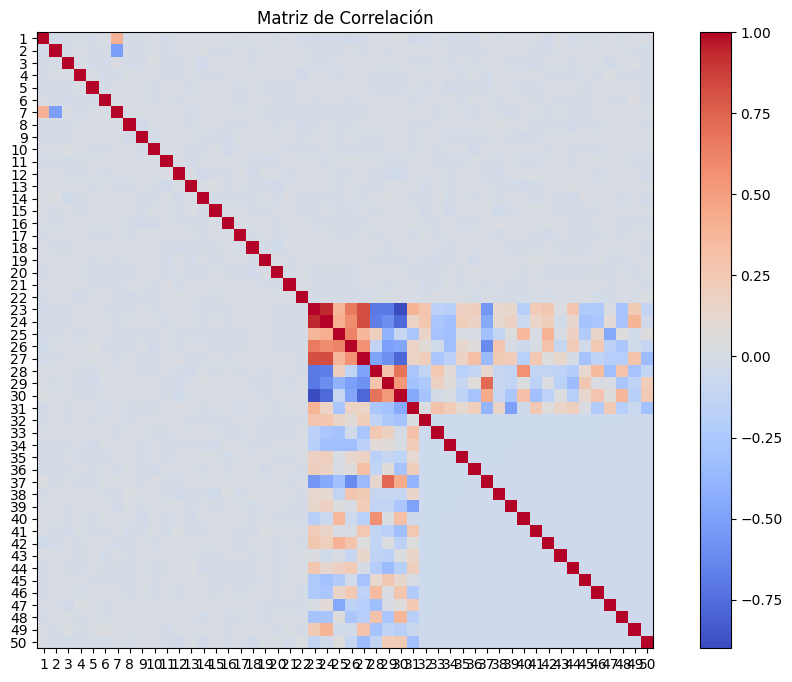

In [16]:
columnas = len(vector_df.select("features").first()[0])
# Calcular la matriz de correlación
correlation_matrix = Correlation.corr(vector_df, "features").head()

# Obtener la matriz de correlación en formato de matriz NumPy
correlation_array = correlation_matrix[0].toArray()

# Crear un gráfico de correlación utilizando Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix[0].toArray(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Matriz de Correlación")
plt.xticks(range(columnas), range(1, columnas + 1), rotation=0)
plt.yticks(range(columnas), range(1, columnas + 1))
plt.show()

Parece ser que los datos presentan poca correlación entre si,  ya que solo los datos sobre el pais de la persona muestra más variedad entre los colores.

## Escalar los datos
Escalamos los datos usando RobustScaler ya que como vimos anteriormente hay varios datos atipicos, y este metodo se caracteriza por no verse afectado tanto por ellos

In [17]:
# Crea el objeto StandardScaler
scaler  = StandardScaler(inputCol="features", outputCol="scaled_features")

# Ajusta el modelo de escala a tus datos
scalerModel  = scaler .fit(vector_df)
# Transforma los datos para obtener las características escaladas en "scaled_features"
scaled_df = scalerModel.transform(vector_df)
scaled_df=scaled_df.select('scaled_features','Heart Attack Risk')
scaled_df.show()

+--------------------+-----------------+
|     scaled_features|Heart Attack Risk|
+--------------------+-----------------+
|(50,[0,1,2,3,5,7,...|              0.0|
|(50,[0,1,2,3,4,5,...|              0.0|
|(50,[0,1,2,3,4,8,...|              0.0|
|(50,[0,1,2,3,4,5,...|              0.0|
|(50,[0,1,2,3,4,7,...|              0.0|
|(50,[0,1,2,3,4,5,...|              0.0|
|(50,[0,1,2,3,8,9,...|              0.0|
|(50,[0,1,2,3,7,8,...|              0.0|
|(50,[0,1,2,3,4,8,...|              0.0|
|(50,[0,1,2,3,4,5,...|              0.0|
|(50,[0,1,2,3,4,5,...|              1.0|
|(50,[0,1,2,3,9,11...|              1.0|
|(50,[0,1,2,3,4,9,...|              0.0|
|(50,[0,1,2,3,8,9,...|              1.0|
|(50,[0,1,2,3,5,7,...|              0.0|
|(50,[0,1,2,3,5,7,...|              0.0|
|(50,[0,1,2,3,5,7,...|              0.0|
|(50,[0,1,2,3,5,7,...|              0.0|
|(50,[0,1,2,3,5,8,...|              0.0|
|(50,[0,1,2,3,5,7,...|              0.0|
+--------------------+-----------------+
only showing top

## Analisis de componentes principales

### PCA

In [18]:
explained_variance = []
k_values = [20,30,35,36,37,38,40,45,50]  # Valores de k que deseas probar
#k_values = [15,20,25,31]
for k in k_values:
    pca = PCA(k=k, inputCol="scaled_features", outputCol="pca_features")
    model = pca.fit(scaled_df)
    
    # Calcula la varianza explicada acumulada
    variance_explained = sum(model.explainedVariance)
    explained_variance.append(variance_explained)
    print(f"Variance explained for k={k}: {variance_explained}")

# Encuentra el valor de k que cumple tus criterios
desired_explained_variance = 0.95  # Puedes ajustar este valor según tus necesidades
selected_k = None

for i, variance in enumerate(explained_variance):
    if variance >= desired_explained_variance:
        selected_k = k_values[i]
        break

print(f"Selected k based on {desired_explained_variance} explained variance: {selected_k}")

23/10/19 20:34:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Variance explained for k=20: 0.6166566961933189


Variance explained for k=30: 0.818339692730853
Variance explained for k=35: 0.9141052215762642


Variance explained for k=36: 0.9328841704126354


Variance explained for k=37: 0.9514247324966159


Variance explained for k=38: 0.9697471412515759
Variance explained for k=40: 0.9950493022686558


Variance explained for k=45: 0.9999999999999982
Variance explained for k=50: 1.0
Selected k based on 0.95 explained variance: 37


In [19]:
pca = PCA(k=selected_k, inputCol="scaled_features", outputCol="pca_features")
model = pca.fit(scaled_df)
data_with_pca = model.transform(scaled_df)
data_with_pca=data_with_pca.select('pca_features','Heart Attack Risk')
data_with_pca=data_with_pca.withColumnRenamed("pca_features","scaled_features")
data_with_pca.show()

+--------------------+-----------------+
|     scaled_features|Heart Attack Risk|
+--------------------+-----------------+
|[-2.1945656383644...|              0.0|
|[-2.2780465540914...|              0.0|
|[-7.0219682313651...|              0.0|
|[-6.9972452564372...|              0.0|
|[-1.5390967539018...|              0.0|
|[-2.3753971579114...|              0.0|
|[1.91019099045477...|              0.0|
|[-2.3520053242472...|              0.0|
|[-6.8292867349959...|              0.0|
|[-6.1236478493641...|              0.0|
|[-2.2556977407360...|              1.0|
|[-6.8079734827750...|              1.0|
|[-1.5724712768823...|              0.0|
|[-1.6586141167093...|              1.0|
|[-1.6150578828565...|              0.0|
|[-7.0153738359350...|              0.0|
|[-5.8776369774358...|              0.0|
|[-6.4848425790950...|              0.0|
|[-2.2892481767387...|              0.0|
|[-1.6570062838237...|              0.0|
+--------------------+-----------------+
only showing top

## Separar los datos de entrenamiento y Test

In [20]:
# Divide los datos en conjuntos de entrenamiento (80%) y prueba (20%)
train_ratio = 0.8
test_ratio = 0.2
seed = 42  # Seed para reproducibilidad

### Con PCA
#train_data, test_data = data_with_pca.randomSplit([train_ratio, test_ratio], seed=seed)

### Sin PCA
#train_data, test_data = data_with_pca.randomSplit([train_ratio, test_ratio], seed=seed)
train_data, test_data = scaled_df.randomSplit([train_ratio, test_ratio], seed=seed)

### Aplicar Oversampling OR  Undersampling

In [24]:
train_data.count()

7078

In [25]:
major_df = train_data.filter(col("Heart Attack Risk") == 0)
minor_df = train_data.filter(col("Heart Attack Risk") == 1)
n = major_df.count()-minor_df.count()

print(f"diff: {n}")
print(major_df.count())
print(minor_df.count())

diff: 1948
4513
2565


**Oversampling**

In [26]:
sample=minor_df.sample(fraction=1.0,seed=42).limit(n)
sample.count()

1948

In [27]:
train_data_oversampling= train_data.unionAll(sample)
train_data_oversampling.count()

9026

**Undersampling**

In [28]:
sample=major_df.sample(fraction=1.0,seed=42).limit(minor_df.count())
sample.count()

2565

In [29]:
train_data_Undersampling= sample.unionAll(minor_df)
train_data_Undersampling.count()

5130

## Entrenar el Modelo RandomForestClassifier

In [30]:
# Clasificador RandomForest
rf = RandomForestClassifier(labelCol="Heart Attack Risk", featuresCol="scaled_features")

# Evaluador para las métricas de evaluación (precisión, recall, F1)
evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk", predictionCol="prediction", metricName="accuracy")

# Grilla de parámetros para búsqueda de hiperparámetros (opcional)
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [4, 5, 10, 20]) \
    .addGrid(rf.seed, [42]) \
    .build()

In [31]:
# Crea el pipeline
pipeline = Pipeline(stages=[rf])

# Configura K-fold Cross Validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5,
                          seed=42)

In [32]:
# Ajusta el modelo con los datos
model1 = crossval.fit(train_data)

23/10/19 20:35:45 WARN DAGScheduler: Broadcasting large task binary with size 1210.5 KiB
23/10/19 20:35:45 WARN DAGScheduler: Broadcasting large task binary with size 1487.0 KiB
23/10/19 20:35:46 WARN DAGScheduler: Broadcasting large task binary with size 1765.0 KiB
23/10/19 20:35:46 WARN DAGScheduler: Broadcasting large task binary with size 2027.0 KiB
23/10/19 20:35:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/19 20:35:48 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/10/19 20:35:48 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/10/19 20:35:49 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/10/19 20:35:49 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/10/19 20:35:50 WARN DAGScheduler: Broadcasting large task binary with size 1770.3 KiB
23/10/19 20:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1360.0 KiB
23/10/19 20:35:59 WARN DAGScheduler:

In [33]:
best_model = model1.bestModel

# Luego, puedes acceder a los hiperparámetros del modelo
best_numTreesr = best_model.stages[-1].getOrDefault("numTrees")
best_maxDepth = best_model.stages[-1].getOrDefault("maxDepth")

# Imprime los hiperparámetros seleccionados
print(f"Mejor numTrees: {best_numTreesr}")
print(f"Mejor maxDepth: {best_maxDepth}")

Mejor numTrees: 50
Mejor maxDepth: 4


## Evaluar el modelo

In [34]:
# Evalúa el modelo en el conjunto de datos de prueba
predictions = model1.transform(test_data)

In [35]:
# Métricas de evaluación
accuracy = evaluator.evaluate(predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
f1 = evaluator.setMetricName("f1").evaluate(predictions)

In [36]:
# Obtener la columna de etiquetas reales y predichas
labelsAndPredictions = predictions.select("Heart Attack Risk", "prediction")

# Seleccionar las filas donde 'diagnosis' es igual a 1 y 'prediction' es igual a 0
false_negatives_df = predictions.filter((col("Heart Attack Risk") == 1) & (col("prediction") == 0))

# Muestra las filas con falsos negativos
false_negatives=false_negatives_df.count()

In [37]:
# Muestra las métricas
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Falsos Negativos: {false_negatives}")

Accuracy: 0.6593471810089021
Precision: 0.4347387051043859
Recall: 0.6593471810089021
F1 Score: 0.5239876381265309
Falsos Negativos: 574


## Analisis de los resultados de RandomForestClassifier

Los resultados obtenidos por el modelo "RandomForestClassifier" muestran datos que son bastantes bajos, siendo el "normal" (sin ningun tipo de balanceo o seleccion de caracteristicas) él que da más alto en Accuracy, Recall. Sin embargo, en un analisis de salud, los Falsos positivos y la Precision (verdaderos positivos) son indicadores que nos pueden interesar más y en este tema le  "Undersampling" tiene mejores datos, pero notamos que en F1 (combinación de recall y presicion) el Oversampling es el alto, por lo que podria ser el una opción para este tipo de problema.


| Tipo de Muestreo      | Accuracy             | Precision            | Recall               | F1 Score             | Falsos Negativos     |
|-----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| Oversampling   | 0.6100890207715134   | 0.5313522769844429   | 0.6100890207715134   | 0.5448959126307752   | 514                  |
| Undersampling  | 0.5020771513353116   | 0.5488086656468922   | 0.5020771513353115   | 0.5150225580409427   | 296                  |
| Normal                | 0.6593471810089021   | 0.4347387051043859   | 0.6593471810089021   | 0.5239876381265309   | 574                  |
| PCA            | 0.6498516320474778   | 0.4223071436747704   | 0.6498516320474778   | 0.5119334799222935   | 590                  |


## Entrenar el Modelo Multilayer perceptron classifier

In [38]:
num_features = len(train_data.select("scaled_features").first()[0])
num_classes = train_data.select("Heart Attack Risk").distinct().count()
print(f"num_features: {num_features}")
print(f"num_classes: {num_classes}")

num_features: 50
num_classes: 2


In [39]:
# Configura el MLP
layers = [num_features, 25, 15, num_classes]  # Esto define la arquitectura de la red, ajusta los valores según tu caso.
#Supported options: l-bfgs, gd
mlp = MultilayerPerceptronClassifier(featuresCol="scaled_features", labelCol="Heart Attack Risk", layers=layers)

# Configura el evaluador
evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk", predictionCol="prediction", metricName="accuracy")

# Grilla de parámetros para búsqueda de hiperparámetros (opcional)
paramGrid = ParamGridBuilder() \
    .addGrid(mlp.maxIter, [30, 50, 100, 150]) \
    .addGrid(mlp.blockSize, [63, 128, 256]) \
    .addGrid(mlp.seed, [42]) \
    .build()

In [40]:
# Crea el pipeline
pipeline = Pipeline(stages=[mlp])

# Configura K-fold Cross Validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5,
                          seed=42)

In [41]:
model2 = crossval.fit(train_data)

In [42]:
best_model = model2.bestModel

# Luego, puedes acceder a los hiperparámetros del modelo
best_maxIter = best_model.stages[-1].getOrDefault("maxIter")
best_blockSize = best_model.stages[-1].getOrDefault("blockSize")

# Imprime los hiperparámetros seleccionados
print(f"Mejor maxIter: {best_maxIter}")
print(f"Mejor blockSize: {best_blockSize}")

Mejor maxIter: 30
Mejor blockSize: 256


## Evaluar el modelo

In [43]:
# Evalúa el modelo en el conjunto de datos de prueba
predictions = model2.transform(test_data)

In [44]:
# Métricas de evaluación
accuracy = evaluator.evaluate(predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
f1 = evaluator.setMetricName("f1").evaluate(predictions)

In [45]:
labelsAndPredictions = predictions.select("Heart Attack Risk", "prediction")

# Seleccionar las filas donde 'diagnosis' es igual a 1 y 'prediction' es igual a 0
false_negatives_df = predictions.filter((col("Heart Attack Risk") == 1) & (col("prediction") == 0))

# Muestra las filas con falsos negativos
false_negatives=false_negatives_df.count()

In [46]:
# Muestra las métricas
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Falsos Negativos: {false_negatives}")

Accuracy: 0.655786350148368
Precision: 0.5540412222311333
Recall: 0.655786350148368
F1 Score: 0.5296161776249686
Falsos Negativos: 567


## Analisis de los resultados de Multilayer perceptron classifier

Los resultados obtenidos por el modelo "Multilayer perceptron classifier" muestran datos son bastantes bajos para un modelo binario, siendo Normal el que tiene más alto el Accuracy, Recall. Sin embargo, en un analisis de salud, los Falsos positivos y la Precision (verdaderos positivos) son indicadores que nos pueden interesar y en este tema le "Oversampling" parece ser el mejor en mejores datos, pero notamos que en F1 (combinacion de recall y presicion) el Undersampling resalta, por lo que podria ser el mejor opción este tipo de problema.


| Tipo de Muestreo  | Accuracy             | Precision            | Recall               | F1 Score             | Falsos Negativos     |
|--------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| Oversampling       | 0.5157270029673591   | 0.5531285641327629   | 0.5157270029673591   | 0.5276586273774193   | 309                  |
| Undersampling      | 0.5192878338278932   | 0.551055953886389    | 0.5192878338278932   | 0.5303124742379394   | 321                  |
| PCA         | 0.6462908011869436   | 0.46537771454961435  | 0.6462908011869437   | 0.511299907248817    | 589                  |
| Normal             | 0.655786350148368    | 0.5540412222311333   | 0.655786350148368    | 0.5296161776249686   | 567                  |


# Comparación de los modelos

Cuando comparamos el modelo "RandomForestClassifier" contra "Multilayer perceptron classifier" notamos que en todas sus versiones tienen a dar valores parecido. Ambos presentan el mejor accuracy  en 65%  y en el F1 score el RandomForestClassifier solo supera al otro por 0.2%. Esto puedo deberse a que los datos realmente no nos aportan mucha información para conocer un  evento tan aleatorio como un ataque cardiaco, esto basandonos en los resultados y al ver que la matrix de correlacion preacticamnete es 0 en todas las columnas, a excepcion de las de pais, se observa una baja correlacion entre los datos. Ademas, al revisar otros trabajos realizados con los mismos datos notamos un resultado similar [2].



Sin embargo, al ver las columans podemos ver que tenemos bastante información de la persona que podria llevarnos a conocer su salud por lo que aumentar el número de muestras o cambiar los hiperparametros podria llevarmos a un mejor modelo.



# Referencia

[1 ] Epes, V. (2022, febrero 21). ¿Qué hacemos con los valores atípicos (outliers)? [Blog]. Blog de Victory Epes. https://victoryepes.blogs.upv.es/2022/02/21/que-hacemos-con-los-valores-atipicos-outliers/

[2] Ranamalla Nithin Reddy. (2022, 22 de agosto). HeartAttackRisk 🩺 Predictive Analysis. Kaggle. https://www.kaggle.com/code/nithinreddy90/heartattackrisk-predictive-analysis

